# Facial Keypoints: Baseline Model
#### Joe Izenman, Thong Bui, Nabeel Siddiqi

In [94]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.parsers import read_csv
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

pd.options.mode.chained_assignment = None

Load the training data from the local file. This model will make use of a broken out dev set, so it won't need the test data.

In [38]:
train = read_csv("data/training.csv")
print(train.count())

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

## Data Processing Functions

Utility functions for loading and processing the data. Many of the preprocessing steps informed by http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/.

In [91]:
# Take a raw data set, loaded from a file such as training.csv, and process into a useful format
# Can specify a subset of columns, whether to only retain complete cases, and a random_state for consistent behavior
def load(raw, cols=None, complete=True, rstate=30):    
    # Filter to a subset of colums (but always include Image)
    if cols:
        tmp = raw[list(cols) + ['Image']]
    else:
        tmp = raw
    
    # If complete=True, only include complete cases of this column subset.
    if complete:
        tmp = tmp.dropna()
    
    # Convert the Image field into a numpy array
    tmp['Image'] = tmp['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    # Extract and scale the features (image)
    data = np.vstack(tmp['Image'].values) / 255
    data = data.astype(np.float32)
    
    # Extract and scale labels (target coordinates to between -1 and 1)
    labels = tmp[tmp.columns[:-1]].values
    labels = (labels - 48) / 48
    labels = labels.astype(np.float32)
    
    data, labels = shuffle(data, labels, random_state=rstate)  # shuffle train data
    
    return data, labels

# Convert the image vector to a square for convolution and display
def img_vec_to_square(img):
    return img.reshape(96,96)

# Convert a square image back to an image vector
def img_square_to_vec(img):
    return img.reshape(9216)

# Split a data set into training and dev data. Defaults to 20% dev data.
def dev_split(data, labels, dev_pct=.2):
    split_point = int(round(data.shape[0] * (1-dev_pct),0))
    train_data, train_labels = data[:split_point], labels[:split_point]
    dev_data, dev_labels = data[split_point:], labels[split_point:]
    return train_data, train_labels, dev_data, dev_labels

# Plot a face with optional prediction and label dots    
def plot_face(ax, data, preds=None, labs=None):
    # Shape the pixel data into a square
    img = img_vec_to_square(data)
    # Display the image
    ax.imshow(img, cmap='gray')
    # Mark the predictions in red
    if preds is not None:
        ax.scatter(preds[0::2]*48+48, preds[1::2]*48+48, marker='.', s=10, c='r')
    # Mark the true labels in yellow
    if labs is not None:
        ax.scatter(labs[0::2]*48+48, labs[1::2]*48+48, marker='.', s=10, c='y')
    
    ax.get_yaxis().set_ticklabels([])
    ax.get_xaxis().set_ticklabels([])

## Data Processing

Process the raw data, and split into dev and training sets.

In [61]:
data, labels = load(train)
train_data, train_labels, dev_data, dev_labels = dev_split(data, labels)
print(data.shape)
print(labels.shape)
print(train_data.shape, train_labels.shape, dev_data.shape, dev_labels.shape)

(2140, 9216)
(2140, 30)
(1712, 9216) (1712, 30) (428, 9216) (428, 30)


## Baseline Model: Complete Cases

Start with a linear regression model of all points. The default scoring of sklearn's LinearRegression is R^2, but Kaggle will be scoring on Root Mean Squared Error.

In [100]:
lm_all = LinearRegression()
lm_all.fit(train_data, train_labels)
lm_all_pred = lm_all.predict(dev_data)
lm_all_r2 = lm_all.score(dev_data, dev_labels)
lm_all_rmse = np.sqrt(mean_squared_error(dev_labels, lm_all_pred))

In [101]:
print("R^2 Score: ", lm_all_r2)
print("RMSE Score: ", lm_all_rmse)

R^2 Score:  0.281116268177
RMSE Score:  0.0538398694953


The RMSE score seems way better than it ought to be, so I suspect I am doing something wrong here. Maybe need to calculate separately for each feature? It's also possible that it's just very easy to get a good score when only using complete cases, if they are all pretty well centered. Not sure.

Next, we plot a few faces from the dev set, with red dots for the predictions, and yellow dots for the original labels.

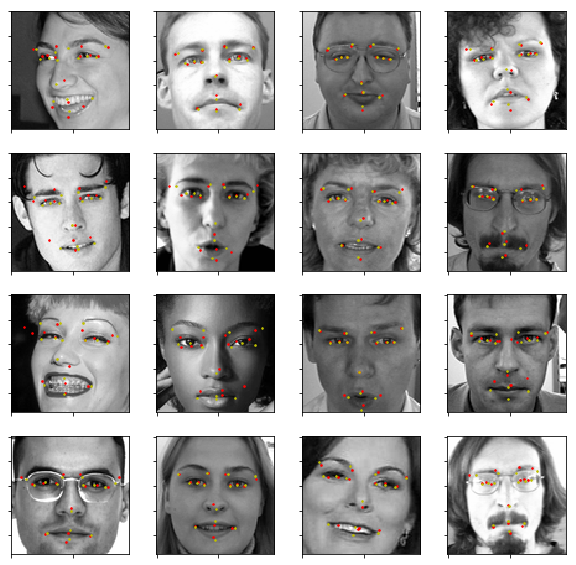

In [92]:
fig, axarr = plt.subplots(4,4)
fig.set_figwidth(10)
fig.set_figheight(10)
for i in range(0, 16):
    ax = axarr[i//4,i%4]
    plot_face(ax, dev_data[i], preds=lm_all_pred[i], labs=dev_labels[i])

In [1]:
# Data Augmentation (original code from: http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/)
from nolearn.lasagne import BatchIterator

class FlipBatchIterator(BatchIterator):
    """This class can be passed directly to the batch_iterator_train variable of the 
    Neural Net class of Lasagne."""
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, y


Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
